In [1]:
import kagglehub
from pathlib import Path
import pandas as pd 
import numpy as np
import torch
import shap
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


In [2]:
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")
path = Path(path)
test_df = pd.read_csv(path / "Test.csv")
train_df = pd.read_csv(path / "Train.csv")
train_df.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)
model.eval()

BATCH_SIZE = 32

def get_embeddings_batch(texts_batch, model, tokenizer, device):
    """
    Generates BERT embeddings for a batch of texts.
    """
    inputs = tokenizer(
        texts_batch, 
        return_tensors='pt', 
        padding=True,
        truncation=True,
        max_length=256
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
    return cls_embeddings.cpu().detach().numpy()

all_embeddings_list = []

if 'train_df' in globals() and isinstance(train_df, pd.DataFrame) and not train_df.empty:
    print(f"Processing train_df with {len(train_df)} texts...")
    if 'text' not in train_df.columns:
        print("Warning: 'text' column not found in train_df. Skipping train_df processing.")
    else:
        train_texts = train_df['text'].tolist()
        for i in tqdm(range(0, len(train_texts), BATCH_SIZE), desc="Embedding Train Batches"):
            batch_texts = train_texts[i:i+BATCH_SIZE]
            if batch_texts:
                batch_embeddings = get_embeddings_batch(batch_texts, model, tokenizer, device)
                all_embeddings_list.extend(batch_embeddings)
else:
    print("train_df is not defined, not a DataFrame, or is empty. Skipping train_df processing.")

if 'test_df' in globals() and isinstance(test_df, pd.DataFrame) and not test_df.empty:
    print(f"\nProcessing test_df with {len(test_df)} texts...")
    if 'text' not in test_df.columns:
        print("Warning: 'text' column not found in test_df. Skipping test_df processing.")
    else:
        test_texts = test_df['text'].tolist()
        for i in tqdm(range(0, len(test_texts), BATCH_SIZE), desc="Embedding Test Batches"):
            batch_texts = test_texts[i:i+BATCH_SIZE]
            if batch_texts:
                batch_embeddings = get_embeddings_batch(batch_texts, model, tokenizer, device)
                all_embeddings_list.extend(batch_embeddings)
else:
    print("\ntest_df is not defined, not a DataFrame, or is empty. Skipping test_df processing.")

if all_embeddings_list:
    final_embeddings_array = np.array(all_embeddings_list)
    print(f"\nGenerated embeddings of shape: {final_embeddings_array.shape}")
    np.save('bert_embeddings.npy', final_embeddings_array)
    print("Embeddings saved to 'bert_embeddings.npy'")
else:
    print("\nNo embeddings were generated as DataFrames were empty, did not exist, or contained no 'text' data.")


Using device: cuda
Processing train_df with 40000 texts...


Embedding Train Batches: 100%|██████████| 1250/1250 [22:49<00:00,  1.10s/it]



Processing test_df with 5000 texts...


Embedding Test Batches: 100%|██████████| 157/157 [02:53<00:00,  1.11s/it]



Generated embeddings of shape: (45000, 768)
Embeddings saved to 'bert_embeddings.npy'


Using device: cuda
Successfully loaded 'bert_embeddings.npy' with shape: (45000, 768)
Raw train embeddings shape: (40000, 768)
Raw test embeddings shape: (5000, 768)

Scaling features (embeddings)...
Feature scaling complete.

Created DataLoaders with batch size: 64

PyTorch MLP Model:
SentimentMLP(
  (fc1): Linear(in_features=768, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

Starting training for 25 epochs...
Epoch [1/25], Train Acc: 83.11%, Val Acc: 85.14%
Epoch [2/25], Train Acc: 84.73%, Val Acc: 84.94%
Epoch [3/25], Train Acc: 84.98%, Val Acc: 84.74%
Epoch [4/25], Train Acc: 85.14%, Val Acc: 84.80%
Epoch [5/25], Train Acc: 85.38%, Val Acc: 84.92%
Epoch [6/25], Train Acc: 85.34%, Val Acc: 85.00%
Epoch [7/25], Train Acc: 85.45%, Val Acc: 85.30%
Epoch [8/25], 

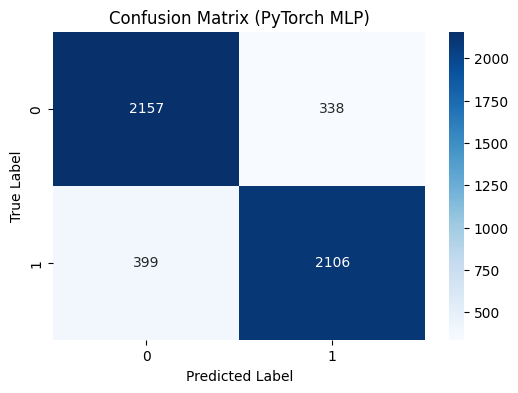

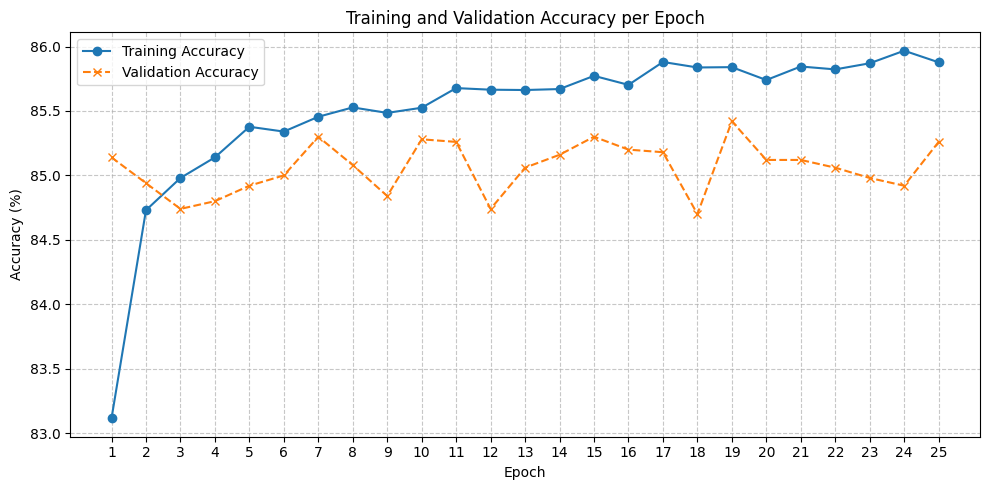


--- PyTorch MLP Classification Example End ---


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler # To ensure we have scaled embeddings
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Load your pre-computed embeddings (same as before) ---
try:
    all_embeddings = np.load('bert_embeddings.npy')
    print(f"Successfully loaded 'bert_embeddings.npy' with shape: {all_embeddings.shape}")
except FileNotFoundError:
    print("Error: 'bert_embeddings.npy' not found.")
    exit()
except Exception as e:
    print(f"Error loading 'bert_embeddings.npy': {e}")
    exit()

# --- 2. Load your original DataFrames to get labels (same as before) ---
if 'train_df' not in globals() or not isinstance(train_df, pd.DataFrame) or 'label' not in train_df.columns:
    print("Warning: 'train_df' with 'label' column not found. Creating dummy for demonstration.")
    num_dummy_train_samples = int(all_embeddings.shape[0] * 0.75) if all_embeddings.shape[0] > 0 else 10
    train_df = pd.DataFrame({'label': np.random.randint(0, 2, num_dummy_train_samples)})
if 'test_df' not in globals() or not isinstance(test_df, pd.DataFrame) or 'label' not in test_df.columns:
    print("Warning: 'test_df' with 'label' column not found. Creating dummy for demonstration.")
    num_dummy_test_samples = all_embeddings.shape[0] - len(train_df) if all_embeddings.shape[0] > len(train_df) else 10
    if num_dummy_test_samples <=0 : num_dummy_test_samples = 10
    test_df = pd.DataFrame({'label': np.random.randint(0, 2, num_dummy_test_samples)})

# --- 3. Prepare Labels and Split Embeddings (same as before) ---
if 'label' not in train_df.columns or 'label' not in test_df.columns:
    print("Error: 'label' column is missing. Cannot proceed.")
    exit()
num_train_samples = len(train_df)
train_embeddings_np = all_embeddings[:num_train_samples]
test_embeddings_np = all_embeddings[num_train_samples:]
train_labels_np = train_df['label'].values
test_labels_np = test_df['label'].values

if train_embeddings_np.shape[0] != train_labels_np.shape[0] or \
   test_embeddings_np.shape[0] != test_labels_np.shape[0] or \
   train_embeddings_np.shape[0] == 0 or test_embeddings_np.shape[0] == 0:
    print("Error: Mismatch in data shapes or empty data. Check data preparation.")
    exit()
    
print(f"Raw train embeddings shape: {train_embeddings_np.shape}")
print(f"Raw test embeddings shape: {test_embeddings_np.shape}")

# --- 4. Feature Scaling (Important for NNs) ---
print("\nScaling features (embeddings)...")
scaler = StandardScaler()
train_embeddings_scaled_np = scaler.fit_transform(train_embeddings_np)
test_embeddings_scaled_np = scaler.transform(test_embeddings_np)
print("Feature scaling complete.")

# --- 5. Convert data to PyTorch Tensors ---
X_train_tensor = torch.tensor(train_embeddings_scaled_np, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels_np, dtype=torch.long)
X_test_tensor = torch.tensor(test_embeddings_scaled_np, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels_np, dtype=torch.long)

# --- 6. Create PyTorch Datasets and DataLoaders ---
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nCreated DataLoaders with batch size: {BATCH_SIZE}")

# --- 7. Define the MLP Model (Same as before) ---
class SentimentMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.5):
        super(SentimentMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

INPUT_DIM = X_train_tensor.shape[1]
HIDDEN_DIM1 = 32
HIDDEN_DIM2 = 16
OUTPUT_DIM = 2
DROPOUT_RATE = 0.5
model = SentimentMLP(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM, DROPOUT_RATE).to(device)
print("\nPyTorch MLP Model:")
print(model)

# --- 8. Define Loss Function and Optimizer (Same as before) ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# --- 9. Training Loop ---
NUM_EPOCHS = 25
train_accuracies = []
val_accuracies = [] 

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    model.train() 
    epoch_train_correct = 0
    epoch_train_total = 0

    for i, (embeddings_batch, labels_batch) in enumerate(train_loader):
        embeddings_batch = embeddings_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        
        # Calculate training accuracy for the batch
        _, predicted_train = torch.max(outputs.data, 1)
        epoch_train_total += labels_batch.size(0)
        epoch_train_correct += (predicted_train == labels_batch).sum().item()

    
    current_epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total
    train_accuracies.append(current_epoch_train_accuracy)
    
    model.eval() 
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for embeddings_batch, labels_batch in test_loader: 
            embeddings_batch = embeddings_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(embeddings_batch)
            _, predicted_val = torch.max(outputs.data, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted_val == labels_batch).sum().item()
    
    current_epoch_val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(current_epoch_val_accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Acc: {current_epoch_train_accuracy:.2f}%, Val Acc: {current_epoch_val_accuracy:.2f}%")


print("Training finished.")

# --- 10. Evaluation (Same as before for metrics, plot will change) ---
model.eval() 
all_preds = []
all_labels = []

with torch.no_grad():
    for embeddings_batch, labels_batch in test_loader:
        embeddings_batch = embeddings_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(embeddings_batch)
        _, predicted_classes = torch.max(outputs.data, 1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy (PyTorch MLP): {accuracy:.4f}")
print("\nClassification Report (PyTorch MLP):")
print(classification_report(all_labels, all_preds))
print("\nConfusion Matrix (PyTorch MLP):")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (PyTorch MLP)')
plt.show()

# Plot training and validation ACCURACY
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, marker='x', linestyle='--', label='Validation Accuracy')
plt.title("Training and Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("\n--- PyTorch MLP Classification Example End ---")


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Corrected imports for AdamW and scheduler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW from torch.optim

from tqdm.notebook import tqdm # For better progress bars in notebooks

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Load Tokenizer and Model for Fine-tuning ---
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)
print(f"Loaded {MODEL_NAME} for sequence classification.")

# --- 2. Load your original DataFrames to get texts and labels ---
# IMPORTANT: Make sure train_df and test_df are loaded in your notebook's global scope
# before this cell runs. They need 'text' and 'label' columns.

if 'train_df' not in globals() or not isinstance(train_df, pd.DataFrame) or \
   'label' not in train_df.columns or 'text' not in train_df.columns:
    print("Warning: 'train_df' with 'text' and 'label' columns not found or incomplete. Creating dummy for demonstration.")
    num_dummy_train_samples = 200
    train_df = pd.DataFrame({
        'text': [f"This is dummy train text example number {i}. It's a lovely day." if i % 2 == 0 else f"This is dummy train text example number {i}. I'm feeling quite sad." for i in range(num_dummy_train_samples)],
        'label': np.array([0 if i % 2 == 0 else 1 for i in range(num_dummy_train_samples)])
    })
    print(f"Created dummy train_df with {len(train_df)} samples.")

if 'test_df' not in globals() or not isinstance(test_df, pd.DataFrame) or \
   'label' not in test_df.columns or 'text' not in test_df.columns:
    print("Warning: 'test_df' with 'text' and 'label' columns not found or incomplete. Creating dummy for demonstration.")
    num_dummy_test_samples = 50
    test_df = pd.DataFrame({
        'text': [f"This is dummy test text example number {i}. What a wonderful experience." if i % 2 == 0 else f"This is dummy test text example number {i}. This is rather disappointing." for i in range(num_dummy_test_samples)],
        'label': np.array([0 if i % 2 == 0 else 1 for i in range(num_dummy_test_samples)])
    })
    print(f"Created dummy test_df with {len(test_df)} samples.")

train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

print(f"Loaded {len(train_texts)} training texts and {len(test_texts)} testing texts.")
print(f"Example train text: '{train_texts[0]}' with label: {train_labels[0]}")
print(f"Unique labels in training data: {np.unique(train_labels)}")
print(f"Unique labels in testing data: {np.unique(test_labels)}")

# --- 3. Create PyTorch Dataset for BERT ---
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 256
BATCH_SIZE = 16

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nCreated DataLoaders with batch size: {BATCH_SIZE} and max_len: {MAX_LEN}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

# --- 4. Define Optimizer and Scheduler ---
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8,
    weight_decay=0.01
)

NUM_EPOCHS = 4
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# --- 5. Training Loop ---
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print(f"\nStarting fine-tuning for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False, unit="batch")

    for batch in progress_bar_train:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()
        _, predicted_train = torch.max(logits, 1)
        epoch_train_total += labels.size(0)
        epoch_train_correct += (predicted_train == labels).sum().item()
        progress_bar_train.set_postfix({'loss': loss.item(), 'acc': (predicted_train == labels).sum().item()/labels.size(0)})

    avg_train_loss = epoch_train_loss / len(train_loader)
    current_epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(current_epoch_train_accuracy)

    model.eval()
    epoch_val_loss = 0
    val_correct = 0
    val_total = 0
    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]", leave=False, unit="batch")
    with torch.no_grad():
        for batch in progress_bar_val:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            epoch_val_loss += loss.item()
            _, predicted_val = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted_val == labels).sum().item()
            progress_bar_val.set_postfix({'val_loss': loss.item(), 'val_acc': (predicted_val == labels).sum().item()/labels.size(0)})

    avg_val_loss = epoch_val_loss / len(test_loader)
    current_epoch_val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(current_epoch_val_accuracy)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {current_epoch_train_accuracy:.2f}%")
    print(f"  Val Loss  : {avg_val_loss:.4f}, Val Acc  : {current_epoch_val_accuracy:.2f}%")

print("\nFine-tuning finished.")

# --- 6. Evaluation ---
model.eval()
all_preds = []
all_labels = []
print("\nEvaluating on the test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        _, predicted_classes = torch.max(logits, 1)
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy (Fine-tuned BERT): {accuracy:.4f}")
print("\nClassification Report (Fine-tuned BERT):")
print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(model.config.num_labels)], zero_division=0))
print("\nConfusion Matrix (Fine-tuned BERT):")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred Class {i}' for i in range(model.config.num_labels)],
            yticklabels=[f'True Class {i}' for i in range(model.config.num_labels)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuned BERT)')
plt.show()

# --- 7. Plot Training History ---
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, marker='x', linestyle='--', label='Validation Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs_range, val_losses, marker='x', linestyle='--', label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

print("\n--- BERT Fine-tuning Example End ---")

# Optional: Save fine-tuned model
output_dir = './bert_sentiment_finetuned/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Fine-tuned model and tokenizer saved to {output_dir}")

ImportError: cannot import name 'AdamW' from 'transformers' (c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\__init__.py)